

# Análise do Banco de Dados da Pesquisa - Telefonia Móvel (Pré-paga)  

### Lucas Marra e Thais D. M. Ferreira

##### Atividade
- Analisar dados de entrevistas de uma pesquisa de satisfação e qualidade percebida, relativa à prestação de Serviço Móvel pessoal (telefonia móvel e banda larga móvel), na modalidade pré-paga

##### Etapas
- Organização, limpeza, exportação e análise gráfica em Python.
- Criar um classificador de satisfação (alta ou baixa) de clientes com bom desempenho preditivo posteriormente em R.

##### Data
- Fonte dos dados e questionário da pesquisa: http://dados.gov.br/dataset/banco-de-dados-da-pesquisatelefonia-movel-pre-paga).
- Descritivo das variáveis no arquivo "variables_description.docx"

  <a id="ancora7"></a>
## Step by step

### O notebook é dividido em 7 partes:

#### 0) Importação de bibliotecas e definições iniciais
        - São importadas as bibliotecas que serão utilizadas na manipulação dos dados
        - Uso da biblioteca de pandas-sql para o tratamento dos principais dados faltantes (NaN) para modelagem
        - Alterações feitas em cada uma das seções são salvas em df e carregadas para seções posteriores

<a name="ancora"></a>

    
[**1) Tratamento de informações de renda**:](#ancora1) Variáveis ```H2``` e ```H2a```
 - Ajustado a faixa salarial quando o usuário não responde valor bruto
 - Ajustado ano de 2015 que tinha padrões de faixas diferentes dos anos seguintes
 - Ajustado para a média geral quando usuário não responde nenhuma das duas perguntas
   
[**2) Tratamento de informações de faixa etária**:](#ancora2) Variável ```Q8```
- Ajustado faixa etária para quando usuário informa somente faixar, utilizando multiplicador para aproximação
   
[**3) Tratamento de informação área de trabalho do entrevistado**:](#ancora3) Variável ```Q2```
- Ajustado para ano de 2015, que apresenta padrão de resposta distinto de meses seguintes
   
[**4.1) a 4.3 Tratamento de informações de satisfação**:](#ancora41) Variáveis ```J1```, ```B1_1```, ```B1_2```, ```C1_1```, ```C1_2```, ```D1```, ```D1_1```, ```D1_2```, ```D1_3```, ```E1_1```, ```E1_2```, ```E1_3```, ```A1_1```, ```A1_2```, ```A1_3```, ```A1_4```, ```A2_1```, ```A2_2```, ```A2_3```, ```A3```, ```A4```, ```A5```, ```F1```, ```F2```, ```F3```, ```F4```, ```F5```, ```F6```
- Uso de tabelas auxiliares (*Dados_AUX, Dados_AUX2 e Dados_AUX3*) para o cálculo da média considerando 4 variáveis: ```OPERADORA```, ```ANO_BASE```, ```Q8a```, ```H2a```
- São feitas todas as combinações possíveis das 4 variáveis, para nota do usuário seja preenchida exatamente pela média do seu grupo em caso de pergunta de satisfação não respondida

[**5) Ajustes finais para extração**:](#ancora5)
- Visualização final dos dados
- Seleção de variáveis que podem ser excluidas do modelo
- Extração em .xlsx

[**6) Visualizações gráficas**:](#ancora6)
- Visualizações com dados finais tratados

## 0) Importação de bibliotecas, pacotes e definições iniciais
- Pandas, Matplotlib, Pandasql
- Leitura de arquivo excel
- Exploração de variáveis (Transposta)
- Head dos dados
- Função para uso de psql

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install pandasql
import pandasql
psql = lambda q: pandasql.sqldf(q, globals()) # Função para uso de SQL
!pip install openpyxl
from openpyxl import workbook
!pip install pyexcel_ods
import pyexcel_ods
from pyexcel_ods import get_data

!pip install pandas_ods_reader
import pandas_ods_reader as pdo

In [2]:
#dados = pd.read_excel("Dados/BD_PRE.csv")
dados = pdo.read_ods("data/BD_PRE.ods","bd_pre")

In [4]:
#Nomes de todas as colunas
head = dados[0:0].T
print(head)

Empty DataFrame
Columns: []
Index: [IDTNS, TIPO, OPERADORA, ESTADO, DATA, ANO_BASE, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q8a, Q9, J1, B1_1, B1_2, C1_1, C1_2, D1, D2_1, D2_2, D2_3, E1_1, E1_2, E1_3, A1_1, A1_2, A1_3, A1_4, A2_1, A2_2, A2_3, A3, A4, A5, F1, F2, F3, F4, F5, F6, G1, H0, COD_IBGE, H1, H2, H2a, H3, I1, I2, PESO]


  <a id="ancora1"></a>
 ## [1) Tratamento de informações de renda](#ancora7)
- Corrigir duas primeiras faixas de salário mínimo de 2015 para até 2 e de 2 a 4 (Renda = H2a, ANO_BASE)
- Identificar o volume e representatividade de pessoas que não informam a faixa salarial em H2(pegar a média)
- Histograma por faixa de renda

In [4]:
### Visualização de médias agrupadas
#ajuste_renda = 'SELECT ANO_BASE, H2a, count(*) AS contagem FROM dados GROUP BY 1,2 order by ANO_BASE asc;'
#ajuste_renda = 'SELECT ANO_BASE, avg(H2a) AS média FROM dados WHERE H2a < 10 GROUP BY 1 order by ANO_BASE asc;'
#ajuste_renda = 'SELECT ANO_BASE, avg(H2a) AS média FROM dados_novo WHERE H2a < 10 GROUP BY 1 order by ANO_BASE asc;'

### Query para pegar média de rendas, quando usuário não responde o salário (H2) 
#ajuste_renda = 'SELECT avg(H2) AS média FROM dados WHERE H2a < 10 and H2 < 88888;'

### Query para pegar média de faixa salarial quando usuário não responde faixa (H2a) 
#ajuste_renda = 'SELECT round(avg(H2a)) AS média FROM dados WHERE H2a < 10;

#psql(ajuste_renda) 

In [5]:
dados_1 = '''Select IDTNS, 
TIPO,
OPERADORA,
ESTADO, 
DATA, 
ANO_BASE, 
Q1,
Q2,
Q3,
Q4, 
Q5,
Q6, 
Q7,
Q8, 
Q8a,
Q9, 
J1, 
B1_1, 
B1_2, 
C1_1, 
C1_2, 
D1, 
D2_1, 
D2_2, 
D2_3, 
E1_1, 
E1_2, 
E1_3, 
A1_1, 
A1_2, 
A1_3, 
A1_4, 
A2_1, 
A2_2, 
A2_3, 
A3, 
A4, 
A5, 
F1, 
F2, 
F3, 
F4, 
F5, 
F6, 
G1, 
H0, 
COD_IBGE, 
H1, 
CASE WHEN H2 > 88888 THEN (SELECT avg(H2) AS média FROM dados WHERE H2a < 10 and H2 < 88888) ELSE H2 END AS H2,
CASE WHEN ANO_BASE = 2015 AND H2 <= 1576 THEN 1 ELSE (CASE WHEN ANO_BASE = 2015 AND H2 BETWEEN 1576 AND 100000 THEN H2a - 1 ELSE (CASE WHEN H2a > 10 THEN (SELECT round(avg(H2a)) AS média FROM dados WHERE H2a < 10) ELSE H2a END) END) END AS H2a, 
H3, 
I1, 
I2, 
PESO 
FROM dados;'''

psql(dados_1) 

,IDTNS,TIPO,OPERADORA,ESTADO,DATA,ANO_BASE,Q1,Q2,Q3,Q4,...,G1,H0,COD_IBGE,H1,H2,H2a,H3,I1,I2,PESO
0,576.0,PRE,OI,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,EXTREMOZ,2403608,1.0,1926.017348,2.0,4.0,3.0,NaN,0.534404
1,971.0,PRE,CLARO,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PARNAMIRIM,2403251,2.0,1926.017348,1.0,2.0,1.0,NaN,0.626276
2,1200.0,PRE,TIM,SE,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,ARACAJU,2800308,1.0,1300.000000,1.0,6.0,1.0,NaN,0.120366
3,1305.0,PRE,OI,GO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,NIQUELANDIA,5214606,4.0,998.000000,1.0,6.0,1.0,NaN,0.613932
4,1349.0,PRE,TIM,TO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PALMAS,1721000,1.0,1926.017348,1.0,7.0,3.0,NaN,0.087025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148011,62039498.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,7.0,1.0,1.0,...,2.0,,,2.0,788.000000,1.0,NaN,1.0,NaN,0.020290
148012,62039589.0,PRE,CLARO,RR,2015-11-27T00:00:00,2015.0,1.0,7.0,1.0,1.0,...,1.0,,,2.0,900.000000,1.0,NaN,2.0,NaN,0.020290
148013,62039655.0,PRE,CLARO,RR,2015-01-12T00:00:00,2015.0,1.0,7.0,1.0,1.0,...,1.0,,,1.0,1926.017348,2.0,NaN,1.0,NaN,0.020290
148014,62039748.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,7.0,1.0,1.0,...,1.0,,,2.0,200.000000,1.0,NaN,1.0,NaN,0.020290


In [6]:
#Ver query como um DataFrame
dados_1 = psql(dados_1)

In [7]:
type(dados_1)

pandas.core.frame.DataFrame

**Obs: ```CASE WHEN``` desta seção não pode ser replicado para partes seguintes para não seguir fazendo cálculo**

  <a id="ancora2"></a>
## [2) Tratamento de informações de faixa etária ](#ancora7)
- Substituição de Q8 aproximação da faixa informada (número da faixa * 7)


In [9]:
#q = 'Select Q8, Q8a from dados LIMIT 100;'
#psql(q) 

In [9]:
dados_2 = '''Select IDTNS, 
TIPO,
OPERADORA,
ESTADO, 
DATA, 
ANO_BASE, 
Q1,
Q2,
Q3,
Q4, 
Q5,
Q6, 
Q7,
CASE WHEN Q8 >= 99 AND Q8a <> 99 THEN Q8a*7 ELSE Q8 END AS Q8, 
Q8a,
Q9, 
J1, 
B1_1, 
B1_2, 
C1_1, 
C1_2, 
D1, 
D2_1, 
D2_2, 
D2_3, 
E1_1, 
E1_2, 
E1_3, 
A1_1, 
A1_2, 
A1_3, 
A1_4, 
A2_1, 
A2_2, 
A2_3, 
A3, 
A4, 
A5, 
F1, 
F2, 
F3, 
F4, 
F5, 
F6, 
G1, 
H0, 
COD_IBGE, 
H1, 
H2,
H2a,
H3, 
I1, 
I2, 
PESO 
FROM dados_1;'''

psql(dados_2) 

,IDTNS,TIPO,OPERADORA,ESTADO,DATA,ANO_BASE,Q1,Q2,Q3,Q4,...,G1,H0,COD_IBGE,H1,H2,H2a,H3,I1,I2,PESO
0,576.0,PRE,OI,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,EXTREMOZ,2403608,1.0,1926.017348,2.0,4.0,3.0,NaN,0.534404
1,971.0,PRE,CLARO,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PARNAMIRIM,2403251,2.0,1926.017348,1.0,2.0,1.0,NaN,0.626276
2,1200.0,PRE,TIM,SE,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,ARACAJU,2800308,1.0,1300.000000,1.0,6.0,1.0,NaN,0.120366
3,1305.0,PRE,OI,GO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,NIQUELANDIA,5214606,4.0,998.000000,1.0,6.0,1.0,NaN,0.613932
4,1349.0,PRE,TIM,TO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PALMAS,1721000,1.0,1926.017348,1.0,7.0,3.0,NaN,0.087025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148011,62039498.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,7.0,1.0,1.0,...,2.0,,,2.0,788.000000,1.0,NaN,1.0,NaN,0.020290
148012,62039589.0,PRE,CLARO,RR,2015-11-27T00:00:00,2015.0,1.0,7.0,1.0,1.0,...,1.0,,,2.0,900.000000,1.0,NaN,2.0,NaN,0.020290
148013,62039655.0,PRE,CLARO,RR,2015-01-12T00:00:00,2015.0,1.0,7.0,1.0,1.0,...,1.0,,,1.0,1926.017348,2.0,NaN,1.0,NaN,0.020290
148014,62039748.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,7.0,1.0,1.0,...,1.0,,,2.0,200.000000,1.0,NaN,1.0,NaN,0.020290


In [10]:
#Ver query como um DataFrame
dados_2 = psql(dados_2)

**Dados tratados para faixa etária**

In [11]:
#q = 'Select Q8, Q8a from dados_1 LIMIT 50;'
#psql(q) 

  <a id="ancora3"></a>
## [3) Tratamento de variável de área de trabalho do entrevistado](#ancora7)
- Correção de dados de 2015 para padrão 0/1 (Sim/Não) de anos seguintes:

In [12]:
#q = 'Select Q2 from dados where ANO_BASE = 2015 LIMIT 50;'

#psql(q) 

In [13]:
dados_3 = '''Select IDTNS, 
TIPO,
OPERADORA,
ESTADO, 
DATA, 
ANO_BASE, 
Q1,
CASE WHEN Q2 = 7 THEN 2 ELSE Q2 END AS Q2,
Q3,
Q4, 
Q5,
Q6, 
Q7,
Q8, 
Q8a,
Q9, 
J1, 
B1_1, 
B1_2, 
C1_1, 
C1_2, 
D1, 
D2_1, 
D2_2, 
D2_3, 
E1_1, 
E1_2, 
E1_3, 
A1_1, 
A1_2, 
A1_3, 
A1_4, 
A2_1, 
A2_2, 
A2_3, 
A3, 
A4, 
A5, 
F1, 
F2, 
F3, 
F4, 
F5, 
F6, 
G1, 
H0, 
COD_IBGE, 
H1, 
H2,
H2a, 
H3, 
I1, 
I2, 
PESO 
FROM dados_2;'''

psql(dados_3) 

,IDTNS,TIPO,OPERADORA,ESTADO,DATA,ANO_BASE,Q1,Q2,Q3,Q4,...,G1,H0,COD_IBGE,H1,H2,H2a,H3,I1,I2,PESO
0,576.0,PRE,OI,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,EXTREMOZ,2403608,1.0,1926.017348,2.0,4.0,3.0,NaN,0.534404
1,971.0,PRE,CLARO,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PARNAMIRIM,2403251,2.0,1926.017348,1.0,2.0,1.0,NaN,0.626276
2,1200.0,PRE,TIM,SE,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,ARACAJU,2800308,1.0,1300.000000,1.0,6.0,1.0,NaN,0.120366
3,1305.0,PRE,OI,GO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,NIQUELANDIA,5214606,4.0,998.000000,1.0,6.0,1.0,NaN,0.613932
4,1349.0,PRE,TIM,TO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PALMAS,1721000,1.0,1926.017348,1.0,7.0,3.0,NaN,0.087025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148011,62039498.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,2.0,,,2.0,788.000000,1.0,NaN,1.0,NaN,0.020290
148012,62039589.0,PRE,CLARO,RR,2015-11-27T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,2.0,900.000000,1.0,NaN,2.0,NaN,0.020290
148013,62039655.0,PRE,CLARO,RR,2015-01-12T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,1.0,1926.017348,2.0,NaN,1.0,NaN,0.020290
148014,62039748.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,2.0,200.000000,1.0,NaN,1.0,NaN,0.020290


In [14]:
#Ver query como um DataFrame
dados_3 = psql(dados_3)

In [15]:
#dados_3

**Dados tratados para Q2 em 2015**

In [16]:
q = 'Select Q2 from dados_3 where ANO_BASE = 2015 LIMIT 50;'

psql(q) 

,Q2
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0
5,2.0
6,2.0
7,2.0
8,2.0
9,2.0


  <a id="ancora41"></a>
## [4.1) Tratamento de variáveis de satisfação geral](#ancora7)
- Transformar resposta de perguntas de satisfação quando entrevistado NR/NS (J1 = 99)
- Variáveis: J1, B1_1, B1_2, C1_1, C1_2, D1, D1_1, D1_2, D1_3, E1_1, E1_2, E1_3
- Substituir valores nulos por médias
    - Criação de **Tabela Auxiliar** para a substituições de valores faltantes utilizando **médias** por operadora, faixa etária, faixa de renda e ano base:  ```OPERADORA```, ```ANO_BASE```, ```Q8a```, ```H2a```
- **Necessário tratar NaN de D2_1, D2_2, D2_3 quando entrevistado responde não para D1?**


In [17]:
#Exploração dos dados
q = 'Select J1, B1_1, B1_2, C1_1, C1_2, D1, D2_1, D2_2, D2_3, E1_1, E1_2, E1_3 from dados_3 WHERE D2_1 IS NULL LIMIT 50;'
psql(q)

,J1,B1_1,B1_2,C1_1,C1_2,D1,D2_1,D2_2,D2_3,E1_1,E1_2,E1_3
0,0.0,10.0,7.0,8.0,10.0,2.0,None,None,None,0.0,0.0,10.0
1,4.0,4.0,5.0,7.0,7.0,2.0,None,None,None,7.0,5.0,8.0
2,6.0,7.0,7.0,5.0,6.0,2.0,None,None,None,1.0,3.0,10.0
3,7.0,10.0,10.0,7.0,7.0,2.0,None,None,None,10.0,10.0,10.0
4,10.0,8.0,8.0,10.0,10.0,2.0,None,None,None,8.0,8.0,8.0
5,9.0,9.0,9.0,8.0,8.0,2.0,None,None,None,8.0,8.0,8.0
6,9.0,8.0,7.0,8.0,7.0,2.0,None,None,None,9.0,8.0,9.0
7,5.0,3.0,5.0,5.0,4.0,2.0,None,None,None,6.0,5.0,8.0
8,10.0,5.0,7.0,10.0,10.0,2.0,None,None,None,99.0,5.0,5.0
9,7.0,8.0,6.0,7.0,9.0,2.0,None,None,None,7.0,5.0,10.0


###### Tabela auxiliar para cálculo das métricas para cada combinação de ```OPERADORA```, ```ANO_BASE```, ```Q8a```, ```H2a```

In [18]:
dados_AUX = '''Select OPERADORA||ANO_BASE||Q8a||H2a as Concatenado, 
AVG(J1) AS M_J1,
AVG(B1_1) AS M_B1_1,
AVG(B1_2) AS M_B1_2,
AVG(C1_1) AS M_C1_1,
AVG(C1_2) AS M_C1_2,
AVG(D2_1) AS M_D2_1,
AVG(D2_2) AS M_D2_2,
AVG(D2_3) AS M_D2_3,
AVG(E1_1) AS M_E1_1,
AVG(E1_2) AS M_E1_2,
AVG(E1_3) AS M_E1_3

FROM dados_3

WHERE J1 <> 99
AND B1_1 <> 99
AND B1_2 <> 99
AND C1_1 <> 99
AND C1_2 <> 99
AND D2_1 IS NOT NULL and D2_1 <> 99
AND D2_2 IS NOT NULL and D2_2 <> 99
AND D2_3 IS NOT NULL and D2_3 <> 99
AND E1_1 <> 99
AND E1_2 <> 99
AND E1_3 <> 99

GROUP BY 1
ORDER BY Concatenado ASC ;'''

psql(dados_AUX)

,Concatenado,M_J1,M_B1_1,M_B1_2,M_C1_1,M_C1_2,M_D2_1,M_D2_2,M_D2_3,M_E1_1,M_E1_2,M_E1_3
0,ALGAR2015.03.01.0,7.113208,7.905660,7.264151,7.150943,6.754717,5.981132,6.301887,5.981132,6.754717,6.132075,7.924528
1,ALGAR2015.03.02.0,7.333333,7.750000,7.444444,8.222222,7.916667,6.305556,6.305556,6.083333,7.638889,7.527778,9.027778
2,ALGAR2015.03.03.0,6.500000,7.000000,7.500000,4.500000,3.500000,7.500000,2.500000,4.000000,5.500000,5.000000,5.500000
3,ALGAR2015.04.01.0,7.113208,7.679245,7.113208,7.301887,6.981132,6.037736,5.849057,5.641509,7.603774,7.264151,8.509434
4,ALGAR2015.04.02.0,6.617021,7.425532,7.000000,7.297872,6.936170,5.702128,5.234043,5.404255,7.957447,6.978723,9.021277
...,...,...,...,...,...,...,...,...,...,...,...,...
896,VIVO2019.08.03.0,7.363636,6.636364,6.909091,8.500000,8.409091,7.545455,7.318182,6.954545,7.000000,7.318182,7.863636
897,VIVO2019.08.04.0,6.600000,6.200000,5.700000,8.100000,7.700000,7.600000,7.500000,7.400000,6.900000,6.600000,8.500000
898,VIVO2019.08.05.0,6.500000,6.500000,7.000000,7.000000,6.375000,6.875000,6.000000,6.750000,6.375000,5.625000,8.250000
899,VIVO2019.09.01.0,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,9.500000,10.000000,10.000000,10.000000


In [19]:
#Ver query como um DataFrame
dados_AUX = psql(dados_AUX)

In [20]:
dados_41 = '''Select IDTNS, 
TIPO,
OPERADORA,
ESTADO,
DATA, 
ANO_BASE, 
Q1,
Q2,
Q3,
Q4, 
Q5,
Q6, 
Q7,
Q8, 
Q8a, 
Q9, 
CASE WHEN J1 = 99 THEN (SELECT M_J1 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE J1 END AS J1,
CASE WHEN B1_1 = 99 THEN (SELECT M_B1_1 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE B1_1 END AS B1_1,
CASE WHEN B1_2 = 99 THEN (SELECT M_B1_2 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE B1_2 END AS B1_2,
CASE WHEN C1_1 = 99 THEN (SELECT M_C1_1 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE C1_1 END AS C1_1, 
CASE WHEN C1_2 = 99 THEN (SELECT M_C1_2 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE C1_2 END AS C1_2, 
D1, 
CASE WHEN D2_1 IS NULL THEN (SELECT M_D2_1 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN D2_1 = 99 THEN (SELECT M_D2_1 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE D2_1 END) END AS D2_1,
CASE WHEN D2_2 IS NULL THEN (SELECT M_D2_2 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN D2_2 = 99 THEN (SELECT M_D2_2 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE D2_2 END) END AS D2_2,
CASE WHEN D2_3 IS NULL THEN (SELECT M_D2_3 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN D2_3 = 99 THEN (SELECT M_D2_3 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE D2_3 END) END AS D2_3, 
CASE WHEN E1_1 = 99 THEN (SELECT M_E1_1 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE E1_1 END AS E1_1, 
CASE WHEN E1_2 = 99 THEN (SELECT M_E1_2 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE E1_2 END AS E1_2,
CASE WHEN E1_3 = 99 THEN (SELECT M_E1_3 FROM dados_AUX WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE E1_3 END AS E1_3,  
A1_1, 
A1_2, 
A1_3, 
A1_4, 
A2_1, 
A2_2, 
A2_3, 
A3, 
A4, 
A5, 
F1, 
F2, 
F3, 
F4, 
F5, 
F6, 
G1, 
H0, 
COD_IBGE, 
H1, 
H2,
H2a, 
H3, 
I1, 
I2, 
PESO 
FROM dados_3;'''

psql(dados_41)

,IDTNS,TIPO,OPERADORA,ESTADO,DATA,ANO_BASE,Q1,Q2,Q3,Q4,...,G1,H0,COD_IBGE,H1,H2,H2a,H3,I1,I2,PESO
0,576.0,PRE,OI,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,EXTREMOZ,2403608,1.0,1926.017348,2.0,4.0,3.0,NaN,0.534404
1,971.0,PRE,CLARO,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PARNAMIRIM,2403251,2.0,1926.017348,1.0,2.0,1.0,NaN,0.626276
2,1200.0,PRE,TIM,SE,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,ARACAJU,2800308,1.0,1300.000000,1.0,6.0,1.0,NaN,0.120366
3,1305.0,PRE,OI,GO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,NIQUELANDIA,5214606,4.0,998.000000,1.0,6.0,1.0,NaN,0.613932
4,1349.0,PRE,TIM,TO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PALMAS,1721000,1.0,1926.017348,1.0,7.0,3.0,NaN,0.087025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148011,62039498.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,2.0,,,2.0,788.000000,1.0,NaN,1.0,NaN,0.020290
148012,62039589.0,PRE,CLARO,RR,2015-11-27T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,2.0,900.000000,1.0,NaN,2.0,NaN,0.020290
148013,62039655.0,PRE,CLARO,RR,2015-01-12T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,1.0,1926.017348,2.0,NaN,1.0,NaN,0.020290
148014,62039748.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,2.0,200.000000,1.0,NaN,1.0,NaN,0.020290


In [21]:
#Ver query como um DataFrame
dados_41 = psql(dados_41)

**Dados tratados para J1, B1_1, B1_2, C1_1, C1_2, E1_1, E1_2, E1_3 (sem 99)**
- Exemplo para conferência: LInhas 25 e 32 apresentavam E1_1 como 99 e foram substituidas por média considerando ```OPERADORA```, ```ANO_BASE```, ```Q8a```, ```H2a```

In [22]:
q = 'Select OPERADORA, ANO_BASE, Q8a, H2a, J1, B1_1, B1_2, C1_1, C1_2, D1, D2_1, D2_2, D2_3, E1_1, E1_2, E1_3 from dados_41 where D2_1 = 99 LIMIT 50;'

psql(q)

,OPERADORA,ANO_BASE,Q8a,H2a,J1,B1_1,B1_2,C1_1,C1_2,D1,D2_1,D2_2,D2_3,E1_1,E1_2,E1_3


  <a id="ancora42"></a>
## [4.2) Tratamento de variáveis de Satisfação com canal de atendimento (Perguntas "A")](#ancora7)
- Transformar resposta de perguntas de A1_01 até A1_4 em 1 ("Sim") e 0 ("Não")

##### Quando resposta para pergunta = "Não", dados são mostrados como NaN

In [23]:
# Exploração dos dados
#q = 'Select A1_1, A1_2, A1_3, A1_4 from dados_41 LIMIT 10;'
#psql(q) 

###### Uso de Pandasql para transformar respostas "Não" de colunas A1_1 até A1_4

In [24]:
dados_42a = '''Select IDTNS, 
TIPO,
OPERADORA,
ESTADO, 
DATA, 
ANO_BASE, 
Q1,
Q2,
Q3,
Q4, 
Q5,
Q6, 
Q7,
Q8, 
Q8a, 
Q9, 
J1,
B1_1,
B1_2,
C1_1, 
C1_2, 
D1, 
D2_1, 
D2_2, 
D2_3, 
E1_1, 
E1_2,
E1_3, 
CASE WHEN A1_1 = 1 THEN 1 ELSE 0 END AS A1_1, 
CASE WHEN A1_2 = 2 THEN 1 ELSE 0 END AS A1_2, 
CASE WHEN A1_3 = 3 THEN 1 ELSE 0 END AS A1_3, 
CASE WHEN A1_4 = 97 THEN 1 ELSE 0 END AS A1_4, 
A2_1, 
A2_2, 
A2_3, 
A3, 
A4, 
A5, 
F1, 
F2, 
F3, 
F4, 
F5, 
F6, 
G1, 
H0, 
COD_IBGE, 
H1, 
H2,
H2a, 
H3, 
I1, 
I2, 
PESO 
FROM dados_41;'''

psql(dados_42a)

,IDTNS,TIPO,OPERADORA,ESTADO,DATA,ANO_BASE,Q1,Q2,Q3,Q4,...,G1,H0,COD_IBGE,H1,H2,H2a,H3,I1,I2,PESO
0,576.0,PRE,OI,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,EXTREMOZ,2403608,1.0,1926.017348,2.0,4.0,3.0,NaN,0.534404
1,971.0,PRE,CLARO,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PARNAMIRIM,2403251,2.0,1926.017348,1.0,2.0,1.0,NaN,0.626276
2,1200.0,PRE,TIM,SE,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,ARACAJU,2800308,1.0,1300.000000,1.0,6.0,1.0,NaN,0.120366
3,1305.0,PRE,OI,GO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,NIQUELANDIA,5214606,4.0,998.000000,1.0,6.0,1.0,NaN,0.613932
4,1349.0,PRE,TIM,TO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PALMAS,1721000,1.0,1926.017348,1.0,7.0,3.0,NaN,0.087025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148011,62039498.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,2.0,,,2.0,788.000000,1.0,NaN,1.0,NaN,0.020290
148012,62039589.0,PRE,CLARO,RR,2015-11-27T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,2.0,900.000000,1.0,NaN,2.0,NaN,0.020290
148013,62039655.0,PRE,CLARO,RR,2015-01-12T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,1.0,1926.017348,2.0,NaN,1.0,NaN,0.020290
148014,62039748.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,2.0,200.000000,1.0,NaN,1.0,NaN,0.020290


In [25]:
#Ver query como um DataFrame
dados_42a = psql(dados_42a)

###### Dados tratados para A1_1 a A1_4

In [26]:
q = 'Select A1_1, A1_2, A1_3, A1_4 from dados_42a LIMIT 50;'

psql(q) 

,A1_1,A1_2,A1_3,A1_4
0,0,0,1,0
1,1,0,1,0
2,0,0,0,1
3,0,1,0,0
4,1,0,0,0
5,0,0,0,1
6,0,1,0,0
7,1,1,1,0
8,0,1,0,0
9,1,1,0,0



- Substituir valores nulos por médias (Semelhante a lógica da **seção 4.1**)
    - Criação de **Tabela Auxiliar** para a substituições de valores faltantes utilizando **médias** por operadora, faixa etária, faixa de renda e ano base:  ```OPERADORA```, ```ANO_BASE```, ```Q8a```, ```H2a```

###### Se A1_1 <> 0 (Atendimento telefônico nos últimos 6 meses)
- A2_1, A2_2, A2_3 = Atendimento telefônico (tempo de espera, necessidade de repetir a demanda, capacidade de esclarecimento)
- A3 = Atendimento telefônico (geral)

###### Se A1_2 <> 0 (Atendimento pela internet nos últimos 6 meses)
- A4 = Atendimento pela internet

###### Se A1_3 <> 0 (Atendimento na loja nos últimos 6 meses)
- A5 = Atendimento na loja

In [27]:
# Quando perguntas de uso nos últimos 6 meses = "Não", perguntas seguintes se registram como NaN
#q = 'Select A1_1, A1_2, A1_3, A1_4, A2_1, A2_2, A2_3, A3, A4, A5 from dados_42a LIMIT 50;'
#psql(q) 

###### Tabela auxiliar para cálculo das métricas para cada combinação de ```OPERADORA```, ```ANO_BASE```, ```Q8a```, ```H2a```

In [28]:
dados_AUX2 = '''Select OPERADORA||ANO_BASE||Q8a||H2a as Concatenado, 
AVG(A2_1) AS M_A2_1,
AVG(A2_2) AS M_A2_2,
AVG(A2_3) AS M_A2_3,
AVG(A3) AS M_A3,
AVG(A4) AS M_A4,
AVG(A5) AS M_A5

FROM dados_42a

WHERE A2_1 IS NOT NULL AND A2_1 <> 99
AND A2_2 IS NOT NULL AND A2_2 <> 99
AND A2_3 IS NOT NULL AND A2_3 <> 99
AND A3 IS NOT NULL AND A3 <> 99
AND A4 IS NOT NULL AND A4 <> 99
AND A5 IS NOT NULL AND A5 <> 99

GROUP BY 1
ORDER BY Concatenado ASC ;'''

psql(dados_AUX2)

,Concatenado,M_A2_1,M_A2_2,M_A2_3,M_A3,M_A4,M_A5
0,ALGAR2015.03.01.0,7.000000,6.500000,7.000000,8.000000,8.000000,8.500000
1,ALGAR2015.03.02.0,7.000000,7.000000,6.333333,7.333333,5.666667,9.000000
2,ALGAR2015.03.03.0,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000
3,ALGAR2015.04.01.0,6.000000,9.250000,9.000000,8.250000,5.000000,5.500000
4,ALGAR2015.04.02.0,7.666667,7.833333,8.333333,7.500000,7.666667,9.166667
...,...,...,...,...,...,...,...
641,VIVO2019.08.02.0,7.636364,8.090909,8.636364,8.090909,8.636364,8.454545
642,VIVO2019.08.03.0,8.500000,9.500000,10.000000,10.000000,9.500000,7.500000
643,VIVO2019.08.05.0,5.000000,8.000000,8.000000,5.000000,8.000000,8.000000
644,VIVO2019.09.01.0,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000


In [29]:
#Ver query como um DataFrame
dados_AUX2 = psql(dados_AUX2)

In [30]:
dados_42b = '''Select IDTNS, 
TIPO,
OPERADORA,
ESTADO, 
DATA, 
ANO_BASE, 
Q1,
Q2,
Q3,
Q4, 
Q5,
Q6, 
Q7,
Q8, 
Q8a, 
Q9, 
J1,
B1_1,
B1_2,
C1_1, 
C1_2, 
D1, 
D2_1, 
D2_2, 
D2_3, 
E1_1, 
E1_2,
E1_3, 
A1_1, 
A1_2, 
A1_3, 
A1_4,
CASE WHEN A2_1 IS NULL THEN (SELECT M_A2_1 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN A2_1 = 99 THEN (SELECT M_A2_1 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE A2_1 END) END AS A2_1,
CASE WHEN A2_2 IS NULL THEN (SELECT M_A2_2 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN A2_2 = 99 THEN (SELECT M_A2_2 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE A2_2 END) END AS A2_2,
CASE WHEN A2_3 IS NULL THEN (SELECT M_A2_3 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN A2_3 = 99 THEN (SELECT M_A2_3 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE A2_3 END) END AS A2_3,
CASE WHEN A3 IS NULL THEN (SELECT M_A3 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN A3 = 99 THEN (SELECT M_A3 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE A3 END) END AS A3,
CASE WHEN A4 IS NULL THEN (SELECT M_A4 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN A4 = 99 THEN (SELECT M_A4 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE A4 END) END AS A4,
CASE WHEN A5 IS NULL THEN (SELECT M_A5 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN A5 = 99 THEN (SELECT M_A5 FROM dados_AUX2 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE A5 END) END AS A5,
F1, 
F2, 
F3, 
F4, 
F5, 
F6, 
G1, 
H0, 
COD_IBGE, 
H1, 
H2,
H2a, 
H3, 
I1, 
I2, 
PESO 
FROM dados_42a;'''

psql(dados_42b) 

,IDTNS,TIPO,OPERADORA,ESTADO,DATA,ANO_BASE,Q1,Q2,Q3,Q4,...,G1,H0,COD_IBGE,H1,H2,H2a,H3,I1,I2,PESO
0,576.0,PRE,OI,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,EXTREMOZ,2403608,1.0,1926.017348,2.0,4.0,3.0,NaN,0.534404
1,971.0,PRE,CLARO,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PARNAMIRIM,2403251,2.0,1926.017348,1.0,2.0,1.0,NaN,0.626276
2,1200.0,PRE,TIM,SE,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,ARACAJU,2800308,1.0,1300.000000,1.0,6.0,1.0,NaN,0.120366
3,1305.0,PRE,OI,GO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,NIQUELANDIA,5214606,4.0,998.000000,1.0,6.0,1.0,NaN,0.613932
4,1349.0,PRE,TIM,TO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PALMAS,1721000,1.0,1926.017348,1.0,7.0,3.0,NaN,0.087025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148011,62039498.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,2.0,,,2.0,788.000000,1.0,NaN,1.0,NaN,0.020290
148012,62039589.0,PRE,CLARO,RR,2015-11-27T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,2.0,900.000000,1.0,NaN,2.0,NaN,0.020290
148013,62039655.0,PRE,CLARO,RR,2015-01-12T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,1.0,1926.017348,2.0,NaN,1.0,NaN,0.020290
148014,62039748.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,2.0,200.000000,1.0,NaN,1.0,NaN,0.020290


In [31]:
#Ver query como um DataFrame
dados_42b = psql(dados_42b)

###### Dados tratados para A2_1 até A5

In [32]:
# Quando perguntas de uso nos últimos 6 meses = "Não", perguntas seguintes se registram como NaN
q = 'Select A1_1, A1_2, A1_3, A1_4, A2_1, A2_2, A2_3, A3, A4, A5 from dados_42b where A2_1 = 99 LIMIT 50;'
psql(q) 

,A1_1,A1_2,A1_3,A1_4,A2_1,A2_2,A2_3,A3,A4,A5


  <a id="ancora43"></a>
## [4.3) Tratamento de variáveis de Satisfação com capacidade de resolução (Perguntas "F")](#ancora7)

- Substituir valores nulos por médias (Semelhante a lógica da **seção 4.1** e **seção 4.2**) 
    - Criação de **Tabela Auxiliar** para a substituições de valores faltantes utilizando **médias** por operadora, faixa etária, faixa de renda e ano base:  ```OPERADORA```, ```ANO_BASE```, ```Q8a```, ```H2a```


In [33]:
#Exploração dos dados
#q = 'Select F1, F2, F3, F4, F5, F6 from dados_42 LIMIT 50;'

#psql(q) 

###### Tabela auxiliar para cálculo das métricas para cada combinação de ```OPERADORA```, ```ANO_BASE```, ```Q8a```, ```H2a```

In [34]:
dados_AUX3 = '''Select OPERADORA||ANO_BASE||Q8a||H2a as Concatenado, 

AVG(F2) AS M_F2,
AVG(F4) AS M_F4,
AVG(F5) AS M_F5,
AVG(F6) AS M_F6,
AVG(H1) AS M_H1

FROM dados_42b

WHERE F2 IS NOT NULL AND F2 <> 99
AND F4 IS NOT NULL AND F4 <> 99
AND F5 IS NOT NULL AND F5 <> 99
AND F6 IS NOT NULL AND F6 <> 99
AND H1 < 30

GROUP BY 1
ORDER BY Concatenado ASC ;'''

psql(dados_AUX3)

,Concatenado,M_F2,M_F4,M_F5,M_F6,M_H1
0,ALGAR2015.03.01.0,3.500000,7.750000,1.0,6.250000,2.25
1,ALGAR2015.03.02.0,0.000000,0.000000,1.0,0.000000,2.00
2,ALGAR2015.03.03.0,2.000000,0.000000,1.0,0.000000,2.00
3,ALGAR2015.04.01.0,5.250000,6.750000,1.0,5.250000,1.50
4,ALGAR2015.04.02.0,0.000000,0.000000,1.0,0.000000,2.50
...,...,...,...,...,...,...
562,VIVO2019.08.02.0,5.250000,7.000000,1.0,7.000000,1.75
563,VIVO2019.08.03.0,4.500000,2.500000,1.0,2.500000,2.00
564,VIVO2019.08.04.0,3.666667,2.666667,1.0,3.333333,2.00
565,VIVO2019.08.05.0,7.000000,6.000000,1.0,3.000000,1.00


In [35]:
#Ver query como um DataFrame
dados_AUX3 = psql(dados_AUX3)

In [36]:
dados_43 = '''Select IDTNS, 
TIPO,
OPERADORA,
ESTADO, 
DATA, 
ANO_BASE, 
Q1,
Q2,
Q3,
Q4, 
Q5,
Q6, 
Q7,
Q8, 
Q8a, 
Q9, 
J1,
B1_1,
B1_2,
C1_1, 
C1_2, 
D1, 
D2_1, 
D2_2, 
D2_3, 
E1_1, 
E1_2,
E1_3, 
A1_1, 
A1_2, 
A1_3, 
A1_4, 
A2_1,
A2_2, 
A2_3, 
A3,
A4,
A5, 
F1,
CASE WHEN F2 IS NULL THEN (SELECT M_F2 FROM dados_AUX3 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN F2 = 99 THEN (SELECT M_F2 FROM dados_AUX3 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE F2 END) END AS F2, 
F3,
CASE WHEN F4 IS NULL THEN (SELECT M_F4 FROM dados_AUX3 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN F4 = 99 THEN (SELECT M_F4 FROM dados_AUX3 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE F4 END) END AS F4,
CASE WHEN F5 IS NULL THEN (SELECT M_F5 FROM dados_AUX3 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN F5 = 99 THEN (SELECT M_F5 FROM dados_AUX3 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE F5 END) END AS F5,
CASE WHEN F6 IS NULL THEN (SELECT M_F6 FROM dados_AUX3 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE (CASE WHEN F6 = 99 THEN (SELECT M_F6 FROM dados_AUX3 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE F6 END) END AS F6, 
G1, 
H0, 
COD_IBGE,
CASE WHEN H1 > 30 THEN (SELECT M_H1 FROM dados_AUX3 WHERE OPERADORA||ANO_BASE||Q8a||H2a = Concatenado) ELSE H1 END AS H1, 
H2,
H2a, 
H3, 
I1, 
I2, 
PESO 
FROM dados_42b;'''

psql(dados_43) 

,IDTNS,TIPO,OPERADORA,ESTADO,DATA,ANO_BASE,Q1,Q2,Q3,Q4,...,G1,H0,COD_IBGE,H1,H2,H2a,H3,I1,I2,PESO
0,576.0,PRE,OI,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,EXTREMOZ,2403608,1.0,1926.017348,2.0,4.0,3.0,NaN,0.534404
1,971.0,PRE,CLARO,RN,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PARNAMIRIM,2403251,2.0,1926.017348,1.0,2.0,1.0,NaN,0.626276
2,1200.0,PRE,TIM,SE,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,ARACAJU,2800308,1.0,1300.000000,1.0,6.0,1.0,NaN,0.120366
3,1305.0,PRE,OI,GO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,NIQUELANDIA,5214606,4.0,998.000000,1.0,6.0,1.0,NaN,0.613932
4,1349.0,PRE,TIM,TO,2019-08-07T00:00:00,2019.0,1.0,2.0,1.0,1.0,...,NaN,PALMAS,1721000,1.0,1926.017348,1.0,7.0,3.0,NaN,0.087025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148011,62039498.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,2.0,,,2.0,788.000000,1.0,NaN,1.0,NaN,0.020290
148012,62039589.0,PRE,CLARO,RR,2015-11-27T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,2.0,900.000000,1.0,NaN,2.0,NaN,0.020290
148013,62039655.0,PRE,CLARO,RR,2015-01-12T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,1.0,1926.017348,2.0,NaN,1.0,NaN,0.020290
148014,62039748.0,PRE,CLARO,RR,2015-11-30T00:00:00,2015.0,1.0,2.0,1.0,1.0,...,1.0,,,2.0,200.000000,1.0,NaN,1.0,NaN,0.020290


In [37]:
#Ver query como um DataFrame
dados_43 = psql(dados_43)

###### Dados tratados para F2, F4, F5 e F6

In [39]:
q = 'Select F1, F2, F3, F4, F5, F6 from dados_43 LIMIT 10;'
psql(q) 

,F1,F2,F3,F4,F5,F6
0,1.0,0.000000,1.0,10.000000,1.0,4.625000
1,1.0,10.000000,1.0,10.000000,2.0,8.714286
2,2.0,3.777778,2.0,3.666667,1.0,4.222222
3,2.0,6.200000,2.0,6.800000,2.0,6.200000
4,1.0,6.000000,1.0,6.000000,1.0,5.846154
5,2.0,5.550000,2.0,5.550000,1.0,5.250000
6,2.0,5.071429,1.0,5.000000,1.0,10.000000
7,2.0,4.933333,2.0,5.466667,2.0,4.666667
8,1.0,0.000000,2.0,4.285714,2.0,3.571429
9,1.0,10.000000,2.0,5.000000,1.0,10.000000


  <a id="ancora5"></a>
## [5) Tratamento final dos dados e arquivo para extração](#ancora7)
- Tratamento final para exportar e **iniciar modelagem estatística em R**:

In [40]:
### Tratamento final para exportar e iniciar em R:

# Excluir colunas:
    # IDTNS(Código do entrevistado)
    # Q1 (Interesse em participar da pesquisa)
    # Q2 (Área de trabalho)
    # Q3 (Ligação atual)
    # Q4 (Principal usuário da linha)
    # Q6 (Tipo de plano)
    # Q7 (Tipo de conta)
    # TIPO (Todas as entradas são "PRE")
    # DATA
    # COD_IBGE (código da cidade)
    # H3 (não explicado no word)
    # I1 (Autorização para identificação)
    # I2 (Autorização para identificação respostas para operadora)
    # G1 que em alguns casos está como "3 - Não sei" (Existência de outra operadora onde entrevistado mora)?
    # H0 (cidades de 2015 em branco)   

In [41]:
dados_final = '''Select 
OPERADORA,
ESTADO, 
ANO_BASE, 
Q5,
Q8, 
Q8a, 
Q9, 
J1,
B1_1,
B1_2,
C1_1, 
C1_2, 
D1, 
D2_1, 
D2_2, 
D2_3, 
E1_1, 
E1_2,
E1_3, 
A1_1, 
A1_2, 
A1_3, 
A1_4, 
A2_1,
A2_2, 
A2_3, 
A3,
A4,
A5, 
F1,
F2,  
F3,
F4, 
F5,
F6,    
H1, 
H2,
H2a,    
PESO 
FROM dados_43

WHERE J1 IS NOT NULL
AND B1_1 IS NOT NULL
AND B1_2 IS NOT NULL
AND C1_1 IS NOT NULL
AND C1_2 IS NOT NULL
AND D2_1 IS NOT NULL
AND D2_2 IS NOT NULL
AND D2_3 IS NOT NULL
AND E1_1 IS NOT NULL
AND E1_2 IS NOT NULL
AND E1_3 IS NOT NULL
AND A2_1 IS NOT NULL
AND A2_2 IS NOT NULL
AND A2_3 IS NOT NULL
AND A3 IS NOT NULL
AND A4 IS NOT NULL
AND A5 IS NOT NULL
AND F2 IS NOT NULL
AND F4 IS NOT NULL
AND F5 IS NOT NULL
AND F6 IS NOT NULL

;'''

psql(dados_final) 

,OPERADORA,ESTADO,ANO_BASE,Q5,Q8,Q8a,Q9,J1,B1_1,B1_2,...,F1,F2,F3,F4,F5,F6,H1,H2,H2a,PESO
0,OI,RN,2019.0,1.0,56.0,8.0,1.0,0.0,10.0,7.0,...,1.0,0.000000,1.0,10.000000,1.0,4.625000,1.0,1926.017348,2.0,0.534404
1,CLARO,RN,2019.0,1.0,56.0,8.0,1.0,10.0,10.0,10.0,...,1.0,10.000000,1.0,10.000000,2.0,8.714286,2.0,1926.017348,1.0,0.626276
2,TIM,SE,2019.0,1.0,40.0,6.0,2.0,4.0,4.0,5.0,...,2.0,3.777778,2.0,3.666667,1.0,4.222222,1.0,1300.000000,1.0,0.120366
3,OI,GO,2019.0,1.0,23.0,3.0,1.0,9.0,8.0,7.0,...,2.0,6.200000,2.0,6.800000,2.0,6.200000,4.0,998.000000,1.0,0.613932
4,TIM,TO,2019.0,1.0,21.0,3.0,1.0,6.0,7.0,7.0,...,1.0,6.000000,1.0,6.000000,1.0,5.846154,1.0,1926.017348,1.0,0.087025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141510,CLARO,RR,2015.0,1.0,62.0,8.0,1.0,8.0,5.0,6.0,...,1.0,10.000000,2.0,6.000000,1.0,4.454545,2.0,788.000000,1.0,0.020290
141511,CLARO,RR,2015.0,1.0,30.0,4.0,1.0,5.0,5.0,6.0,...,2.0,4.428571,2.0,4.800000,2.0,4.557143,2.0,900.000000,1.0,0.020290
141512,CLARO,RR,2015.0,1.0,25.0,4.0,1.0,7.0,5.0,0.0,...,1.0,10.000000,1.0,10.000000,1.0,0.000000,1.0,1926.017348,2.0,0.020290
141513,CLARO,RR,2015.0,1.0,25.0,4.0,1.0,10.0,8.0,6.0,...,1.0,5.000000,2.0,4.800000,1.0,4.557143,2.0,200.000000,1.0,0.020290


In [42]:
#Ver query como um DataFrame
dados_final = psql(dados_final)

In [43]:
### Atualizar pasta que arquivo será salvo se necessário
#dados_final.to_excel("data/BD_Pre_Tratado.xlsx", index = False)

  <a id="ancora6"></a>
## [6) Visualizações](#ancora7)

### Gráficos de pizza, histograma, barras e linha
- Distribuição pesquisas **por operadora**
- Número de pesquisas por faixa de renda **qualidade da conexão por idade**
- Satisfação geral **nos estados da região sudeste**
- Evolução de satisfação com **acesso a internet 3G/4G de 2015 a 2019**

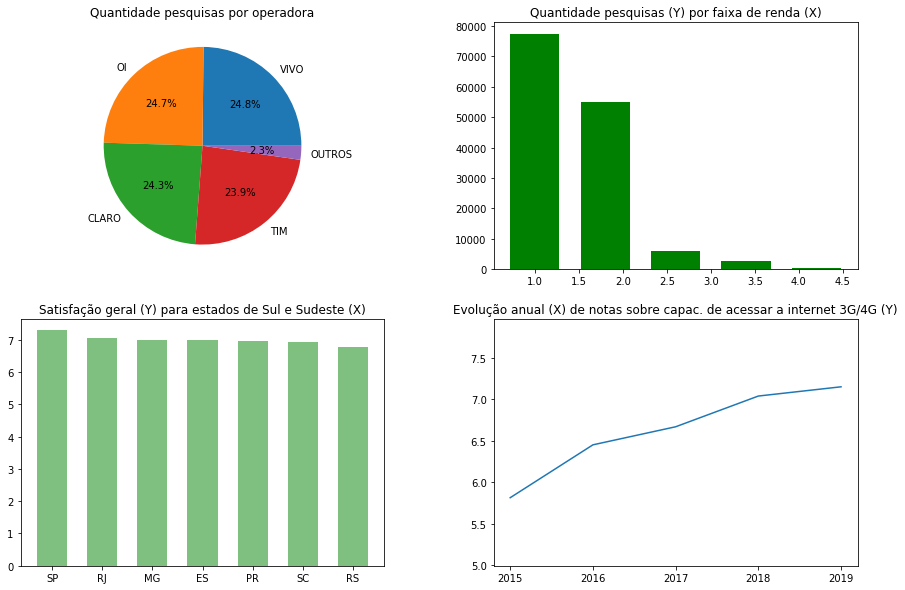

In [44]:
# Gráfico de pizza
ope = 'Select distinct OPERADORA, count (*) as contagem from dados_final group by 1 order by contagem desc;'
ope = psql(ope)
contagem_ope = [ope.contagem[0],ope.contagem[1],ope.contagem[2],ope.contagem[3],ope.contagem[4]+ope.contagem[5]+ope.contagem[6]]

# Histograma
ren = 'Select distinct H2a, count (*) as contagem from dados_final group by 1 order by contagem desc;'
ren = psql(ren)
contagem_ren = [ren.contagem[0],ren.contagem[1],ren.contagem[2],ren.contagem[3],ren.contagem[4]]

# Gráfico de barras
label_col = ['SP','RJ','MG','ES','PR','SC','RS']
x_pos = list(range(len(label_col)))
bar_width = .6
est = 'Select ESTADO, avg(J1) as média from dados_final where ESTADO IN ("SP","RJ","MG","ES","PR","SC","RS") group by 1 order by média desc;'
est = psql(est)
contagem_est = [est.média[0],est.média[1],est.média[2],est.média[3],est.média[4],est.média[5],est.média[6]]

# Gráfico de linhas
label_lin = ['2015','2016','2017','2018','2019']
evo = 'Select ANO_BASE, avg(D2_1) as média from dados_final group by 1 order by ANO_BASE asc;'
evo = psql(evo)
contagem_evo = [evo.média[0],evo.média[1],evo.média[2],evo.média[3],evo.média[4]]


# Plots de cada gráfico
fig, eixos = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

eixos[0,0].pie(contagem_ope, labels=["VIVO","OI","CLARO","TIM", "OUTROS"], autopct="%1.1f%%")
eixos[0,0].set_title("Quantidade pesquisas por operadora")

eixos[0,1].hist(dados_final['H2a'],bins=5,histtype='bar',align='left',rwidth=0.7,color='g')
eixos[0,1].set_title("Quantidade pesquisas (Y) por faixa de renda (X)")

eixos[1,0].x_pos = list(range(len(label_col)))
eixos[1,0].bar_width = .6
eixos[1,0].bar(x_pos, contagem_est, bar_width, align='center',alpha=0.5, label='Estados', color='g')
eixos[1,0].set_title('Satisfação geral (Y) para estados de Sul e Sudeste (X)')
eixos[1,0].set_xticks(x_pos)
eixos[1,0].set_xticklabels(label_col)

eixos[1,1].plot(label_lin,contagem_evo)
eixos[1,1].set_title('Evolução anual (X) de notas sobre capac. de acessar a internet 3G/4G (Y)')

plt.axis('equal')
plt.subplots_adjust(wspace=0.3)
plt.show()


### Gráficos de dispersão 
- Satisfação com acesso a **internet 3G/4G por idade**
- Satisfação com a **qualidade da conexão por idade**
- Satisfação com a velocidade de **navegação por idade**
- Satisfação com velocidade de **navegação por operadora**

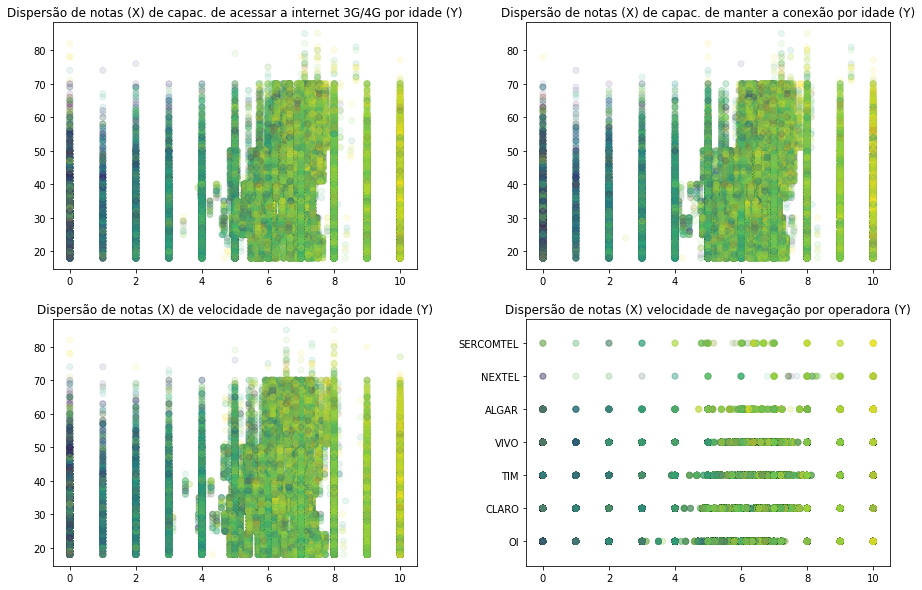

In [45]:
fig, eixos = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

eixos[0,0].scatter(dados_final['D2_1'], dados_final['Q8'], alpha=0.1, c=dados_final['J1'])
eixos[0,0].set_title('Dispersão de notas (X) de capac. de acessar a internet 3G/4G por idade (Y)')
#eixos[0,0].plt.show()
#eixos[0][1].axis('equal')

eixos[0,1].scatter(dados_final['D2_2'], dados_final['Q8'], alpha=0.1, c=dados_final['J1'])
eixos[0,1].set_title('Dispersão de notas (X) de capac. de manter a conexão por idade (Y)')
#eixos[0,1].plt.show()
#eixos[0][1].axis('equal')

eixos[1,0].scatter(dados_final['D2_3'], dados_final['Q8'], alpha=0.1, c=dados_final['J1'])
eixos[1,0].set_title('Dispersão de notas (X) de velocidade de navegação por idade (Y)')
#eixos[1,0].plt.show()
#eixos[1][0].axis('equal')

eixos[1,1].scatter(dados_final['D2_3'], dados_final['OPERADORA'], alpha=0.1, c=dados_final['J1'])
eixos[1,1].set_title('Dispersão de notas (X) velocidade de navegação por operadora (Y)')
#eixos[1,1].plt.show()
#eixos[1][1].axis('equal')

plt.axis('equal')
plt.subplots_adjust(wspace=0.3)
plt.show()
